# CS 5324 Lab 5: Wide and Deep Networks

For this assignment, we will be exploring the [Heart Failure Prediction](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download) dataset. It is a collection of datasets combined into one large dataset. This dataset is composed of observations regarding patients' health traits related to the likelihood of heart failure.

This dataset was sourced from [Kaggle](https://www.kaggle.com/datasets) and consists of 918 observations.

## Team

The team consists of three members:
1. Melodie Zhu
2. Samina Faheem
3. Giancarlos Dominguez

## Dataset Preparation

Let us import our dataset.

In [14]:
# import libraies
import os
import pandas as pd
import numpy as np
import copy

In [15]:
# get dataset from csv file
data_directory = os.getcwd() + '\\data\\heart.csv'
df = pd.read_csv(data_directory)

In [16]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [17]:
print("Shape of the dataset", df.shape)

print(f"\nNumber of observations in the dataset: {df.shape[0]}")
print(f"Number of features in the dataset: {df.shape[1]}")

Shape of the dataset (918, 12)

Number of observations in the dataset: 918
Number of features in the dataset: 12


Next, we will check for any duplicate observations.

In [18]:
# check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 0


Luckily, we don't have to worry about duplicate rows. Now, let us check for rows with missing values.

In [19]:
# check for missing values
print(f"\nNumber of missing values: {df.isnull().sum().sum()}")


Number of missing values: 0


None of our observations have missing values. Therefore, we don't have to worry about holes in our data.

### Defining Class Variables

| Variable Name | Datatype | Description | Values |
:------: | :------: | :------: | :------:|
| `Age` | Numerical int | How old the patient is (yrs) | NA |
| `Sex` | Categorical str | The biological gender of the patient | {**M**: Male, **F**: Female} |
| `ChestPainType` | Categorical str | The chest pain condition of the patient | {**TA**: Typical Angina, **ATA**: Atypical Angina, **NAP**: Non-Anginal Pain, **ASY**: Asymptomatic} |
| `RestingBP` | Numerical int | The resting blood pressure (mmHg) | NA |
| `Cholesterol` | Numerical int | The cholesterol level of the patient (mm/dl) | NA |
| `FastingBS` | Categorical int | The fasting blood sugar level of the patient | {**1**: if FastingBS > 120 (mg/dl), **0**: otherwise }|
| `RestingECG` | Categorical str | The resting electrocardiogram results of the patient | {**Normal**: Normal, **ST**: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), **LVH**: Showing probable or definite left ventricular hypertrophy by Estes' criteria} |
| `MaxHR` | Numerical int | The maximum heart rate recorded in the patient | NA |
| `ExerciseAngina` | Categorical str | Whether the patient has exersice-induced angina | {**Y**: Yes, **N**: No} |
| `OldPeak` | Numerical float | ST segment value of the patient | NA |
| `ST_Slope` | Categorical str | Slope of the peak exercise ST segment | {**Up**: Upsloping, **Flat**: Flat, **Down**: Downsloping} |
| `HeartDisease` | Categorical int | Whether the patient is likely to have heart failure| {**1**: Likely to have heart failure, **0**: Not likely to have heart failure }

Since all of our features are medically related to heart conditions and failure, we will not remove any features from our dataset.<br>

Now, we will convert our categorical variables into integers and standardize our numerical variables.

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df_imputed = copy.deepcopy(df)

# define vars to encode as integer    
encoders = dict()
categorical_headers = [
    'Sex',
    'ChestPainType',
    'RestingECG',
    'ExerciseAngina',
    'ST_Slope'
]

# train all encoders
for col in categorical_headers:
    df_imputed[col] = df_imputed[col].str.strip()
    
    if col == 'HeartDisease':
        tmp = LabelEncoder()
        df_imputed[col] = tmp.fit_transform(df_imputed[col])
    else:
        # integer encode strings that are features
        encoders[col] = LabelEncoder() # save the encoder
        df_imputed[col+'_int'] = encoders[col].fit_transform(df_imputed[col])

# scale numeric, continuous variables
numeric_headers = [
    "Age", 
    "RestingBP", 
    "Cholesterol",
    "MaxHR"
]

ss = StandardScaler()
df_imputed[numeric_headers] = ss.fit_transform(df_imputed[numeric_headers])

include_header =["FastingBS","Oldpeak"]
df_imputed.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_int,ChestPainType_int,RestingECG_int,ExerciseAngina_int,ST_Slope_int
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,0.0,Up,0,1,1,1,0,2
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,1.0,Flat,1,0,2,1,0,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,0.0,Up,0,1,1,2,0,2
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,1.5,Flat,1,0,0,1,1,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,0.0,Up,0,1,2,1,0,2


It should be noted that we encoded our categorical variables into integers. The column names will be denoted by their original name with "_int" added at the end, but their context to the dataset will not change. Below are the variables we will use throughout the lab.

In [21]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers+include_header

import pprint
pp = pprint.PrettyPrinter(indent=4)

print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)

We will use the following 11 features:
[   'Sex_int',
    'ChestPainType_int',
    'RestingECG_int',
    'ExerciseAngina_int',
    'ST_Slope_int',
    'Age',
    'RestingBP',
    'Cholesterol',
    'MaxHR',
    'FastingBS',
    'Oldpeak']


### Cross Product Features

In [22]:
# Identifying the groups of features in the data that should be combined into cross-product features:
# 
# For this dataset, the categorical features are `Sex , ChestPainType , RestingECG, ExerciseAngina , ST_Slope`
# 
# The cross-product operation on the categorical features can be interpreted as logical conjunctions. 
# The significance of the cross-product features is creating the combined features which are more useful 
# to the prediction/classification tasks compared with the independent features .

Since our dataset has 12 features, including our target feature, and we don't want our performance to suffer due to overfitting, we will create 2 cross-product features.

`Age` & `Sex`: Regarding heart failures and condition, older people are more likely to suffer heart failure. Looking only at gender, men are more at risk of having a heart faiure than women. The combination of these features would capture the effect that age and gender have on the likelihood of suffering heart failure. Therefore, we believe it is worth further exploring by combining these features into a cross product.

`Cholesterol` & `RestingBP`: Cholesterol greartly affects the likelihood of someong having a heart failure. However, the team struggled to choose whether to combine it with `RestingBP` or `FastingBS`. Both features also affect the likelihood of heart failure. However, high blood pressure is a more consistant and reliable factor in patients who have heart failure. Additionally, high blood pressure is the leading cause of heart failure in the US. High blood sugar levels can also damage nerves and blood vessels, but it is less reliable since not all people with high blood sugar levels suffer heart failure in their lifetime. Therfore, we chose to create a cross product feature from `Cholesterol` and `RestingBP`.

### Evaluation Method

For evaluating our models' performance, we will not be using accuracy, since it is prone to being skewed depending on how balanced the dataset is, among other factors. Instead, we will be using the recall evalutuation method. We will use this method due to the medical nature of our dataset, making it necessary to account for true positives and false negatives. Predicting false negative have higher consequences in a medical dataset. Hence, Recall should be used instead of accuracy due to the importance of false negatives for this dataset.

### Dataset Splitting Method

For this dataset, we will split it using the stratified 10-fold cross validation. Since we only have 918 observations, we need to maximize the use of our dataset. This method will also ensure that the subsets are as evenly distributed like the class ratio of the overall dataset. By using stratified 10-folds, we ensure that the sub-datasets will not be more unbalanced.

In [32]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score

# we want to predict the X and y data as follows:
X = df_imputed[feature_columns].to_numpy()
y = df_imputed['HeartDisease'].values

# get size of dataset, number of features, and number of classes
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print("Number of observations in dataset: {}".format(n_samples))
print("Number of features in dataset: {}".format(n_features))
print("Number of classes for the target feature (HeartDisease): {}".format(n_classes))

Number of observations in dataset: 918
Number of features in dataset: 11
Number of classes for the target feature (HeartDisease): 2


Number of instances in each class:[410 508]


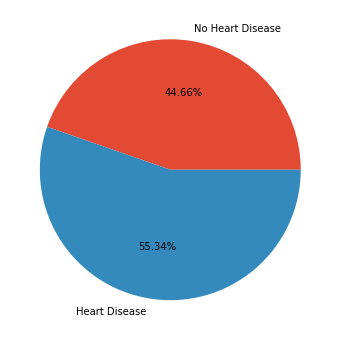

In [35]:
from matplotlib import pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('ggplot')

print('Number of instances in each class:'+str(np.bincount(y)))

# plot piechart of the number of instances in each class
plt.figure(figsize=(6,6))
plt.pie(np.bincount(y), labels=['No Heart Disease', 'Heart Disease'], autopct='%1.2f%%')
plt.show()

From the pie chart above, we observe that the dataset classes are unbalanced. There are more patients with the likelihood of having heart failure than those not likely to have heart disease. With stratified 10-fold cross validation, all of our subsets will have the same 55/44 class ratio to prevent it from becoming further unbalanced.

Now, we will split our dataset.

In [36]:
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedKFold(n_splits=num_cv_iterations)
                         
print(cv_object)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [37]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from sklearn import metrics as mt

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]


Recall score average: 86.86274509803921


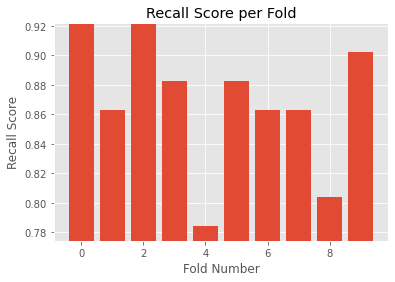

In [51]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# select model
clf = LogisticRegression()
clf.fit(X,y)

#select cross validation
cv = StratifiedShuffleSplit(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(recall_score)

# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

# title and labels
plt.title('Recall Score per Fold')
plt.ylabel('Recall Score')
plt.xlabel('Fold Number')

print(f'Recall score average: {per_fold_eval_criteria.mean()*100}')
plt.show()

Most of our folds have a recall value of 0.9. The closer to 1 the recall score is, the better our model's performance. Since our average recall value among the folds is in the high 0.8's, we can say that our model is performing well.

## Modeling

In [52]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Recall

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
# First, lets setup the input size
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
predictions = Dense(1, activation='sigmoid')(x)

# model with input and 3 dense layers
model = Model(inputs=input_tensor, outputs=predictions)


In [ ]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[Recall()])

model.summary()
model.fit(X_train, y_train, epochs=12, verbose=1)

Observing the model summary, we see that the loss values decreases through each epoch, meaning that the model's number of correct predictions improves. Our recall value increase with each epoch, meaning that it becomes better at predicting the true positives and not mispredicting with false negatives. Overall, these metrics allow us to say that our model's prediction capabilities are not declining.

In [ ]:
import pydot_ng as pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96)

We have some idea of our model's performance, but now we will graph them using a heatmap.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, yhat)

# create number of values in each group
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

# create percentages of each group
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

# create labels
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

`RESULTS CHANGE EACH TIME WE RUN NOTEBOOK, SO THIS HAS TO BE WRITTEN WHEN NOTEBOOK FINALIZED`<br>
Our model is fairly accurate, but it still has some missed predictions. Unfortunately, most of the incorrect predictions fall under the false negative category. Given the nature of our dataset, a false negative can have devastating consequences. Assuming our model would be used in the real world, we would need to make our model much more accurate. We can improve the model itself or provide a bigger dataset for training.

Now let us look at the classification report.

In [ ]:
print(mt.classification_report(y_test,yhat))
print(f"Accuracy of model: {mt.accuracy_score(y_test,yhat)}")

`WRITE WHEN WE RUN NOTEBOOK FOR LAST TIME`

We can observe our model's performance using different evaluation metrics:

`Precision`: measures the accuracy of positive predictions<br>
`Recall`:  measures how many actual positive were predicted correctly<br>
`F1-score`: the average of both precision and recall scores<br>

### First Combination

In order to add one-hot encoding, we need to separate the categorical features that are currently saved as integers and place them into Embedding layers. An embedding layer deals with integers as if they were one-hot encoded.

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate

# start by getting only the categorical variables
# these matrices are all integers
#X_train = df_train[categorical_headers_ints].to_numpy() 
#X_test = df_test[categorical_headers_ints].to_numpy() 

embed_branches = []
all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categircal variables
input_branch = Input(shape=(X_train.shape[1],), 
                     dtype='int64', 
                     name='categorical')

# for each categorical variable
for idx,col in enumerate(categorical_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = df_imputed[col].max()+1 
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_branch, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

model = Model(inputs=input_branch, outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[Recall()])

model.summary()

In [ ]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
model.fit(X_train, y_train, epochs=12, batch_size=50, verbose=1)

In [ ]:
yhat_proba = model.predict(X_test)
yhat1 = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat1))
print(mt.classification_report(y_test,yhat1))

In [ ]:
print(mt.accuracy_score(y_test,yhat))

### Second Combination

In [ ]:
cat_X = df_imputed[categorical_headers_ints].to_numpy()
# we want to predict the X and y data as follows:
cat_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cat_X,cat_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_cat = cat_X[train_indices]
    y_train_cat = cat_y[train_indices]
    
    X_test_cat = cat_X[test_indices]
    y_test_cat = cat_y[test_indices]
    
num_X = df_imputed[categorical_headers_ints].to_numpy()
# we want to predict the X and y data as follows:
num_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(num_X,num_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_num = num_X[train_indices]
    y_train_num = num_y[train_indices]
    
    X_test_num = num_X[test_indices]
    y_test_num = num_y[test_indices]


In [ ]:
# save categorical features
#X_train_cat = df_train[categorical_headers_ints].to_numpy() 
#X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
#X_train_num =  df_[numeric_headers].to_numpy()
#X_test_num = df_test[numeric_headers].to_numpy()

all_branch_outputs = [] # this is where we will keep track of output of each branch

input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_branch_outputs.append(x)
    
# HERE IS THE ADDING OF AN INPUT USING NUMERIC DATA
# create dense input branch for numeric
inputs_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu', name='num_1')(inputs_num)
    
all_branch_outputs.append(x_dense)

# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=10, activation='relu', name='combined_1')(final_branch)
final_branch = Dense(units=1, activation='sigmoid', name='combined_2')(final_branch)

model = Model(inputs=[input_cat,inputs_num], outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[Recall()])

model.summary()

In [ ]:

plot_model(model, 
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='LR',
           expand_nested=False, 
           dpi=96)

In [ ]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=Recall())

model.fit([ X_train_cat, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=12, 
          batch_size=50, 
          verbose=1)

yhat2 = model.predict([X_test_cat,
                      X_test_num]) # each branch has an input

yhat2 = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat2))
print(mt.classification_report(y_test,yhat2))

In [ ]:
print(mt.accuracy_score(y_test,yhat2))

### Third Combination

In [ ]:
cross_columns = [['ChestPainType','RestingECG','ST_Slope'],
                 #['sex', 'marital_status'],
                 #['workclass','occupation'],
                 #['occupation','race','education'],
                 ['Sex','ExerciseAngina']
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_imputed[cols_list].apply(lambda x: '_'.join(x), axis=1)
   # X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_imputed[cross_col_name] = enc.transform(X_crossed_train)
    #df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

In [ ]:
cross_X = df_imputed[cross_col_df_names].to_numpy()
# we want to predict the X and y data as follows:
cross_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cross_X,cross_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_crossed = cross_X[train_indices]
    y_train_crossed = cross_y[train_indices]
    
    X_test_crossed = cross_X[test_indices]
    y_test_crossed = cross_y[test_indices]



In [ ]:
# get crossed columns
#X_train_crossed = df_train[cross_col_df_names].to_numpy()
#X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
#X_train_cat = df_train[categorical_headers_ints].to_numpy() 
#X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
#X_train_num =  df_train[numeric_headers].to_numpy()
#X_test_num = df_test[numeric_headers].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)


In [ ]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)
model.summary()

In [ ]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['Recall'])


In [ ]:
# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=12, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))


In [ ]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

## Graduate Analysis